In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

hp = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

hp.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


## Data Exploration

First I want to look at the target variable's distribution and see if there are any outliers in it. 

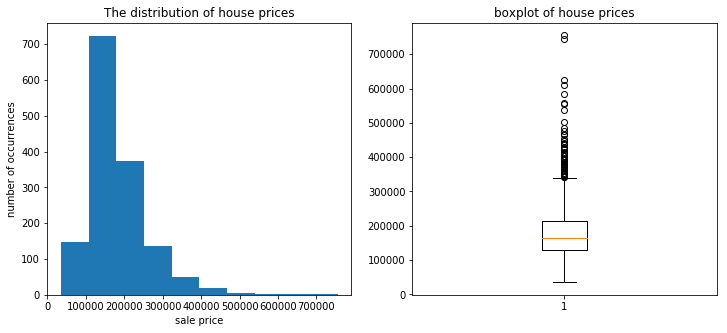

In [10]:
#look at target variable distribution
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.hist(hp.saleprice)
plt.title("The distribution of house prices")
plt.xlabel("sale price")
plt.ylabel("number of occurrences")

plt.subplot(1, 2, 2)
plt.boxplot(hp.saleprice)
plt.title("boxplot of house prices")

plt.show()

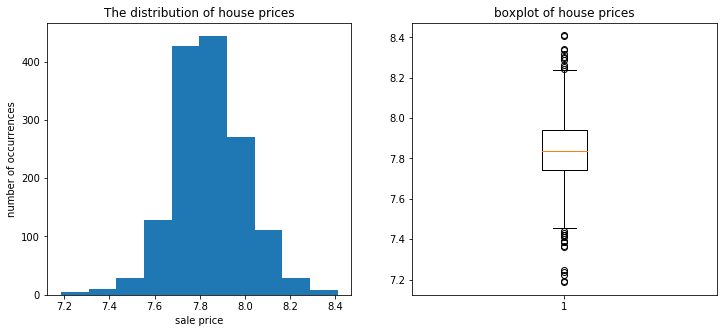

In [7]:
#try a box_cox transformation to remove outliers and create normal distribution 
from scipy.stats import boxcox

saleprice_boxcox,_ = boxcox(hp["saleprice"])

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.hist(saleprice_boxcox)
plt.title("The distribution of house prices")
plt.xlabel("sale price")
plt.ylabel("number of occurrences")

plt.subplot(1, 2, 2)
plt.boxplot(saleprice_boxcox)
plt.title("boxplot of house prices")

plt.show()

In [14]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(saleprice_boxcox)
norm_stats = normaltest(saleprice_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 46.14341032057487 and p value is 9.55181489459278e-11
Normality test statistics is 24.65847941901889 and p value is 4.4205797314700295e-06


Even though the target variable is not normally distributed according to the two normality tests, the distribution looks closer to normal so I will use it as the new target variable. 

In [12]:
#add to data frame
hp['boxcox_saleprice'] = saleprice_boxcox

In [13]:
#examine dataset
hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
id                  1460 non-null int64
mssubclass          1460 non-null int64
mszoning            1460 non-null object
lotfrontage         1201 non-null float64
lotarea             1460 non-null int64
street              1460 non-null object
alley               91 non-null object
lotshape            1460 non-null object
landcontour         1460 non-null object
utilities           1460 non-null object
lotconfig           1460 non-null object
landslope           1460 non-null object
neighborhood        1460 non-null object
condition1          1460 non-null object
condition2          1460 non-null object
bldgtype            1460 non-null object
housestyle          1460 non-null object
overallqual         1460 non-null int64
overallcond         1460 non-null int64
yearbuilt           1460 non-null int64
yearremodadd        1460 non-null int64
roofstyle           1460 non-null object

In order to better visualize and clean the variables I am going to break them down based off whether they are discrete or continuous variables. I will further break down the discrete variables into numeric and non-numeric categories. 

In [24]:
#create list of discrete columns, one numerically discrete and one not, and continuous columns

hp_disc = hp.loc[:, ['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 
             'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl',
             'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
             'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair',
             'electrical', 'kitchenqual', 'functional', 'fireplaces', 'garagetype', 'garagefinish', 'garagequal',
             'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition']]

hp_cat = hp.loc[:, ['overallqual', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
                    'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'mosold', 'yrsold']]

hp_cont = hp.loc[:, ['mssubclass', 'lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 
                     'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 
                     'garageyrblt', 'garagearea', 'wooddecksf','openporchsf', 'threessnporch', 'screenporch', 'poolarea', 
                     'miscval', 'boxcox_saleprice']]

In [16]:
#Create a dictionary for discrete variables, non-numeric
list1 = hp_disc[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
hp_disc_dict = dict( zip( list1, list2))
print(hp_disc_dict)

{'mszoning': 1, 'street': 2, 'alley': 3, 'lotshape': 4, 'landcontour': 5, 'utilities': 6, 'lotconfig': 7, 'landslope': 8, 'neighborhood': 9, 'condition1': 10, 'condition2': 11, 'bldgtype': 12, 'housestyle': 13, 'roofstyle': 14, 'roofmatl': 15, 'exterior1st': 16, 'exterior2nd': 17, 'masvnrtype': 18, 'exterqual': 19, 'extercond': 20, 'foundation': 21, 'bsmtqual': 22, 'bsmtcond': 23, 'bsmtexposure': 24, 'bsmtfintype1': 25, 'bsmtfintype2': 26, 'heating': 27, 'heatingqc': 28, 'centralair': 29, 'electrical': 30, 'kitchenqual': 31, 'functional': 32, 'fireplaces': 33, 'garagetype': 34, 'garagefinish': 35, 'garagequal': 36, 'garagecond': 37, 'paveddrive': 38, 'poolqc': 39, 'fence': 40, 'miscfeature': 41, 'saletype': 42}


In [25]:
#Create a dictionary for categorical variables, numeric
list1 = hp_cat[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
hp_cat_dict = dict( zip( list1, list2))
print(hp_cat_dict)

{'overallqual': 1, 'overallcond': 2, 'bsmtfullbath': 3, 'bsmthalfbath': 4, 'fullbath': 5, 'halfbath': 6, 'bedroomabvgr': 7, 'kitchenabvgr': 8, 'totrmsabvgrd': 9, 'fireplaces': 10, 'garagecars': 11, 'mosold': 12, 'yrsold': 13}


In [18]:
#Create a dictionary for continuous variables
list1 = hp_cont[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
hp_cont_dict = dict( zip( list1, list2))
print(hp_cont_dict)

{'mssubclass': 1, 'lotfrontage': 2, 'lotarea': 3, 'yearbuilt': 4, 'yearremodadd': 5, 'masvnrarea': 6, 'bsmtfinsf1': 7, 'bsmtfinsf2': 8, 'bsmtunfsf': 9, 'totalbsmtsf': 10, 'firstflrsf': 11, 'secondflrsf': 12, 'lowqualfinsf': 13, 'grlivarea': 14, 'garageyrblt': 15, 'garagearea': 16, 'wooddecksf': 17, 'openporchsf': 18, 'threessnporch': 19, 'screenporch': 20, 'poolarea': 21, 'miscval': 22, 'boxcox_saleprice': 23}


The lists I just created will be used to iterate over and visualize the variables. I am choosing to only clean up the continuous variables so first I'll visualize the discrete variables and see which ones appear to have significance with the target variable. 

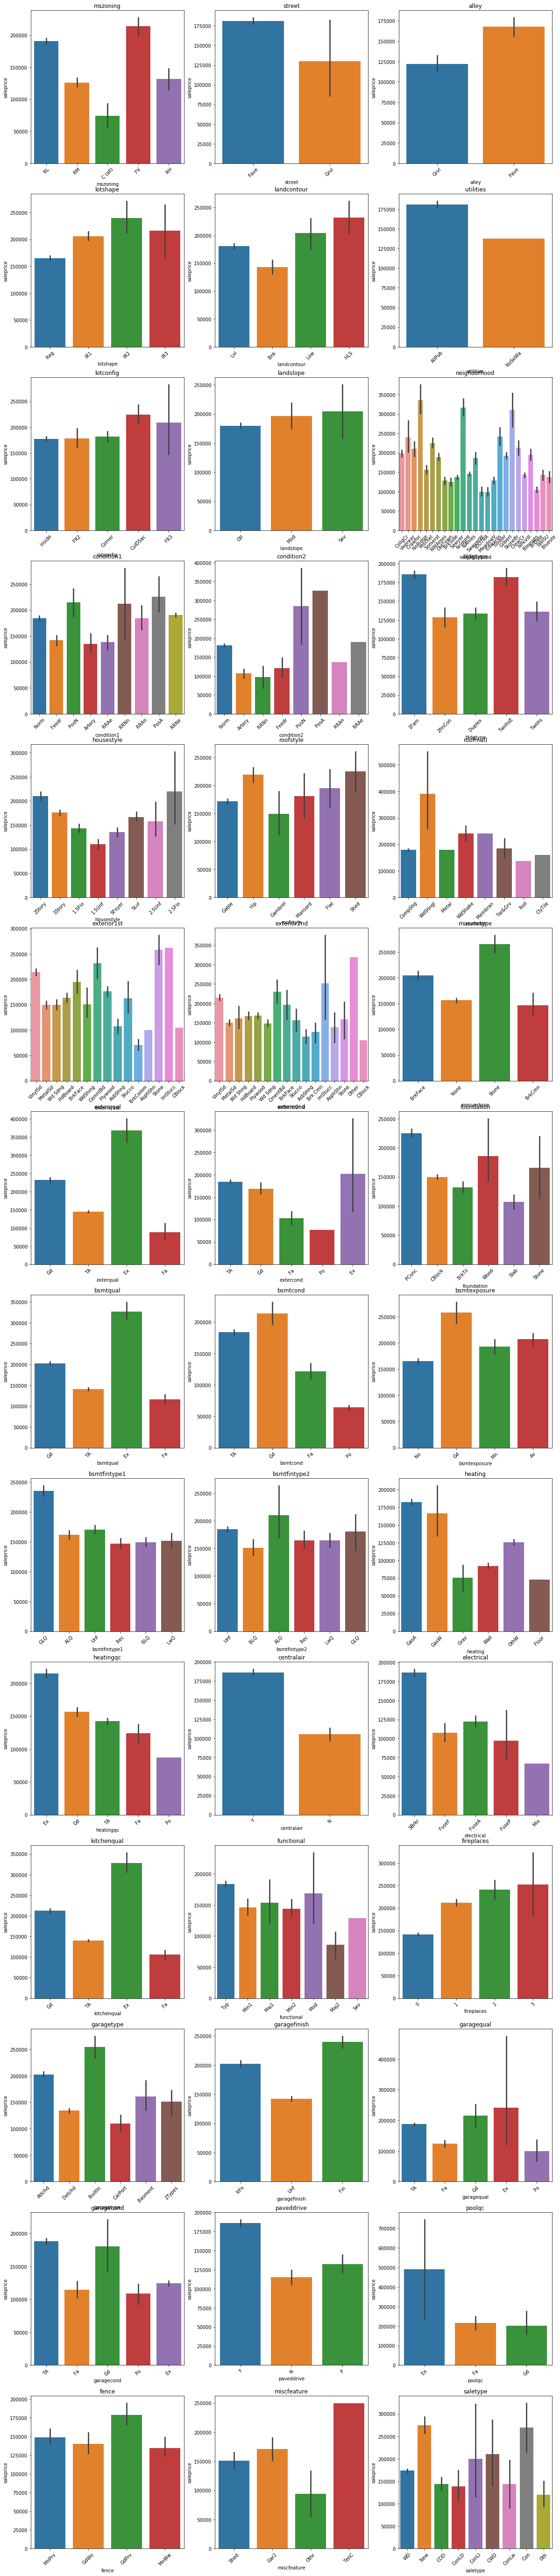

In [22]:
#visualizing discrete, non-numeric variables
plt.figure(figsize=(20,100))

for variable, i in hp_disc_dict.items():
                     plt.subplot(14, 3, i)
                     sns.barplot(hp_disc[variable], hp['saleprice'])
                     plt.xticks(rotation = 45)
                     plt.title(variable)


plt.show()

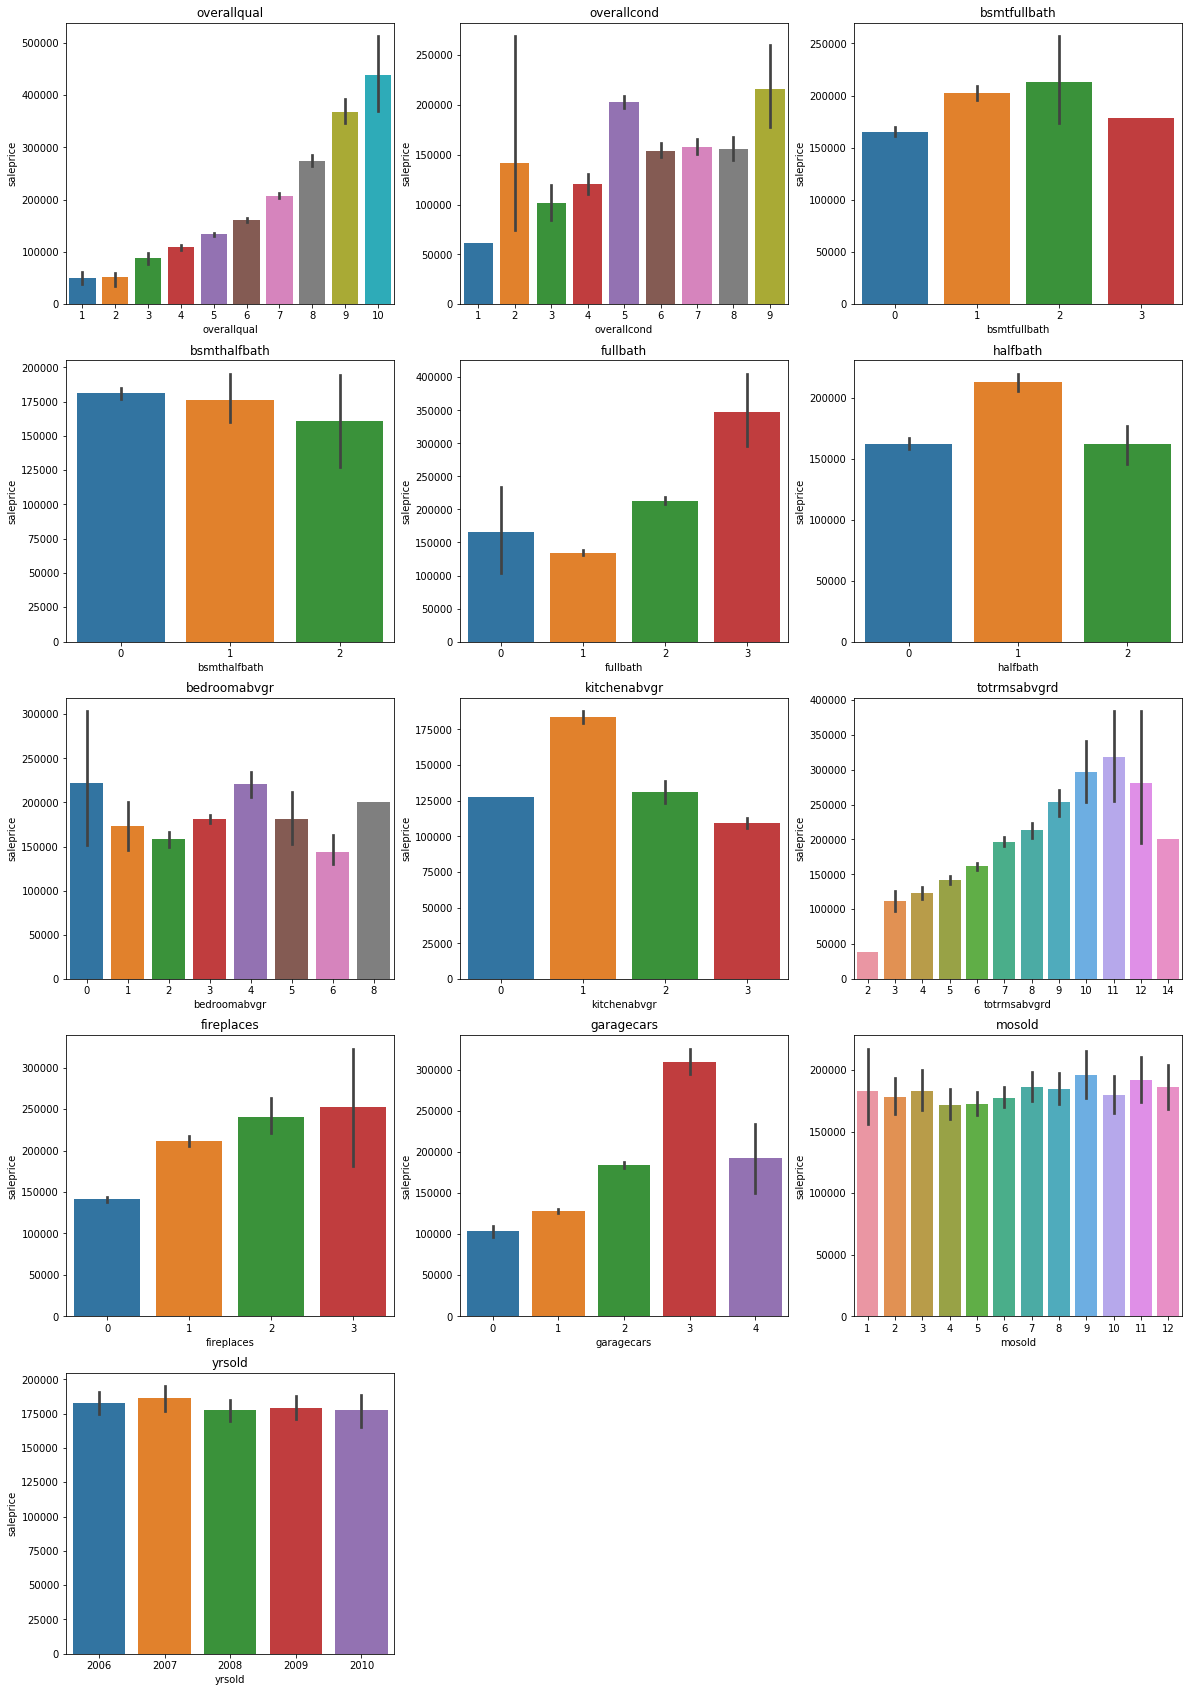

In [26]:
#visualizing discrete, numeric variables
plt.figure(figsize=(20,30))

for variable, i in hp_cat_dict.items():
                     plt.subplot(5, 3, i)
                     sns.barplot(hp_cat[variable], hp['saleprice'])
                     plt.title(variable)


plt.show()

Looking at the discrete variables, garagecars, fullbath, and overallqual seem to have the biggest effect on saleprice.

### Data Cleaning and Exploration
#### Continuous variables 

In [10]:
#find null values
hp_cont.isnull().sum()*100/hp_cont.isnull().count()

mssubclass        0.000000
lotfrontage      17.739726
lotarea           0.000000
yearbuilt         0.000000
yearremodadd      0.000000
masvnrarea        0.547945
bsmtfinsf1        0.000000
bsmtfinsf2        0.000000
bsmtunfsf         0.000000
totalbsmtsf       0.000000
firstflrsf        0.000000
secondflrsf       0.000000
lowqualfinsf      0.000000
grlivarea         0.000000
garageyrblt       5.547945
garagearea        0.000000
wooddecksf        0.000000
openporchsf       0.000000
threessnporch     0.000000
screenporch       0.000000
poolarea          0.000000
miscval           0.000000
saleprice         0.000000
dtype: float64

In [27]:
#fill in missing values with averages
#I've chosen to ignore the garage year built variable
hp_cont['lotfrontage'].fillna(hp_cont['lotfrontage'].mean(), inplace = True)
hp_cont['masvnrarea'].fillna(hp_cont['masvnrarea'].mean(), inplace = True)

In [28]:
#look for abnormal values
for column_name in hp_cont.columns:
    print("Unique values in column {} are: {}".format(column_name, hp_cont[column_name].unique()))

Unique values in column mssubclass are: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
Unique values in column lotfrontage are: [ 65.          80.          68.          60.          84.
  85.          75.          70.04995837  51.          50.
  70.          91.          72.          66.         101.
  57.          44.         110.          98.          47.
 108.         112.          74.         115.          61.
  48.          33.          52.         100.          24.
  89.          63.          76.          81.          95.
  69.          21.          32.          78.         121.
 122.          40.         105.          73.          77.
  64.          94.          34.          90.          55.
  88.          82.          71.         120.         107.
  92.         134.          62.          86.         141.
  97.          54.          41.          79.         174.
  99.          67.          83.          43.         103.
  93.          30.         129.         140. 

Doesn't appear to be any strange or blank values present in our continuous variables. 

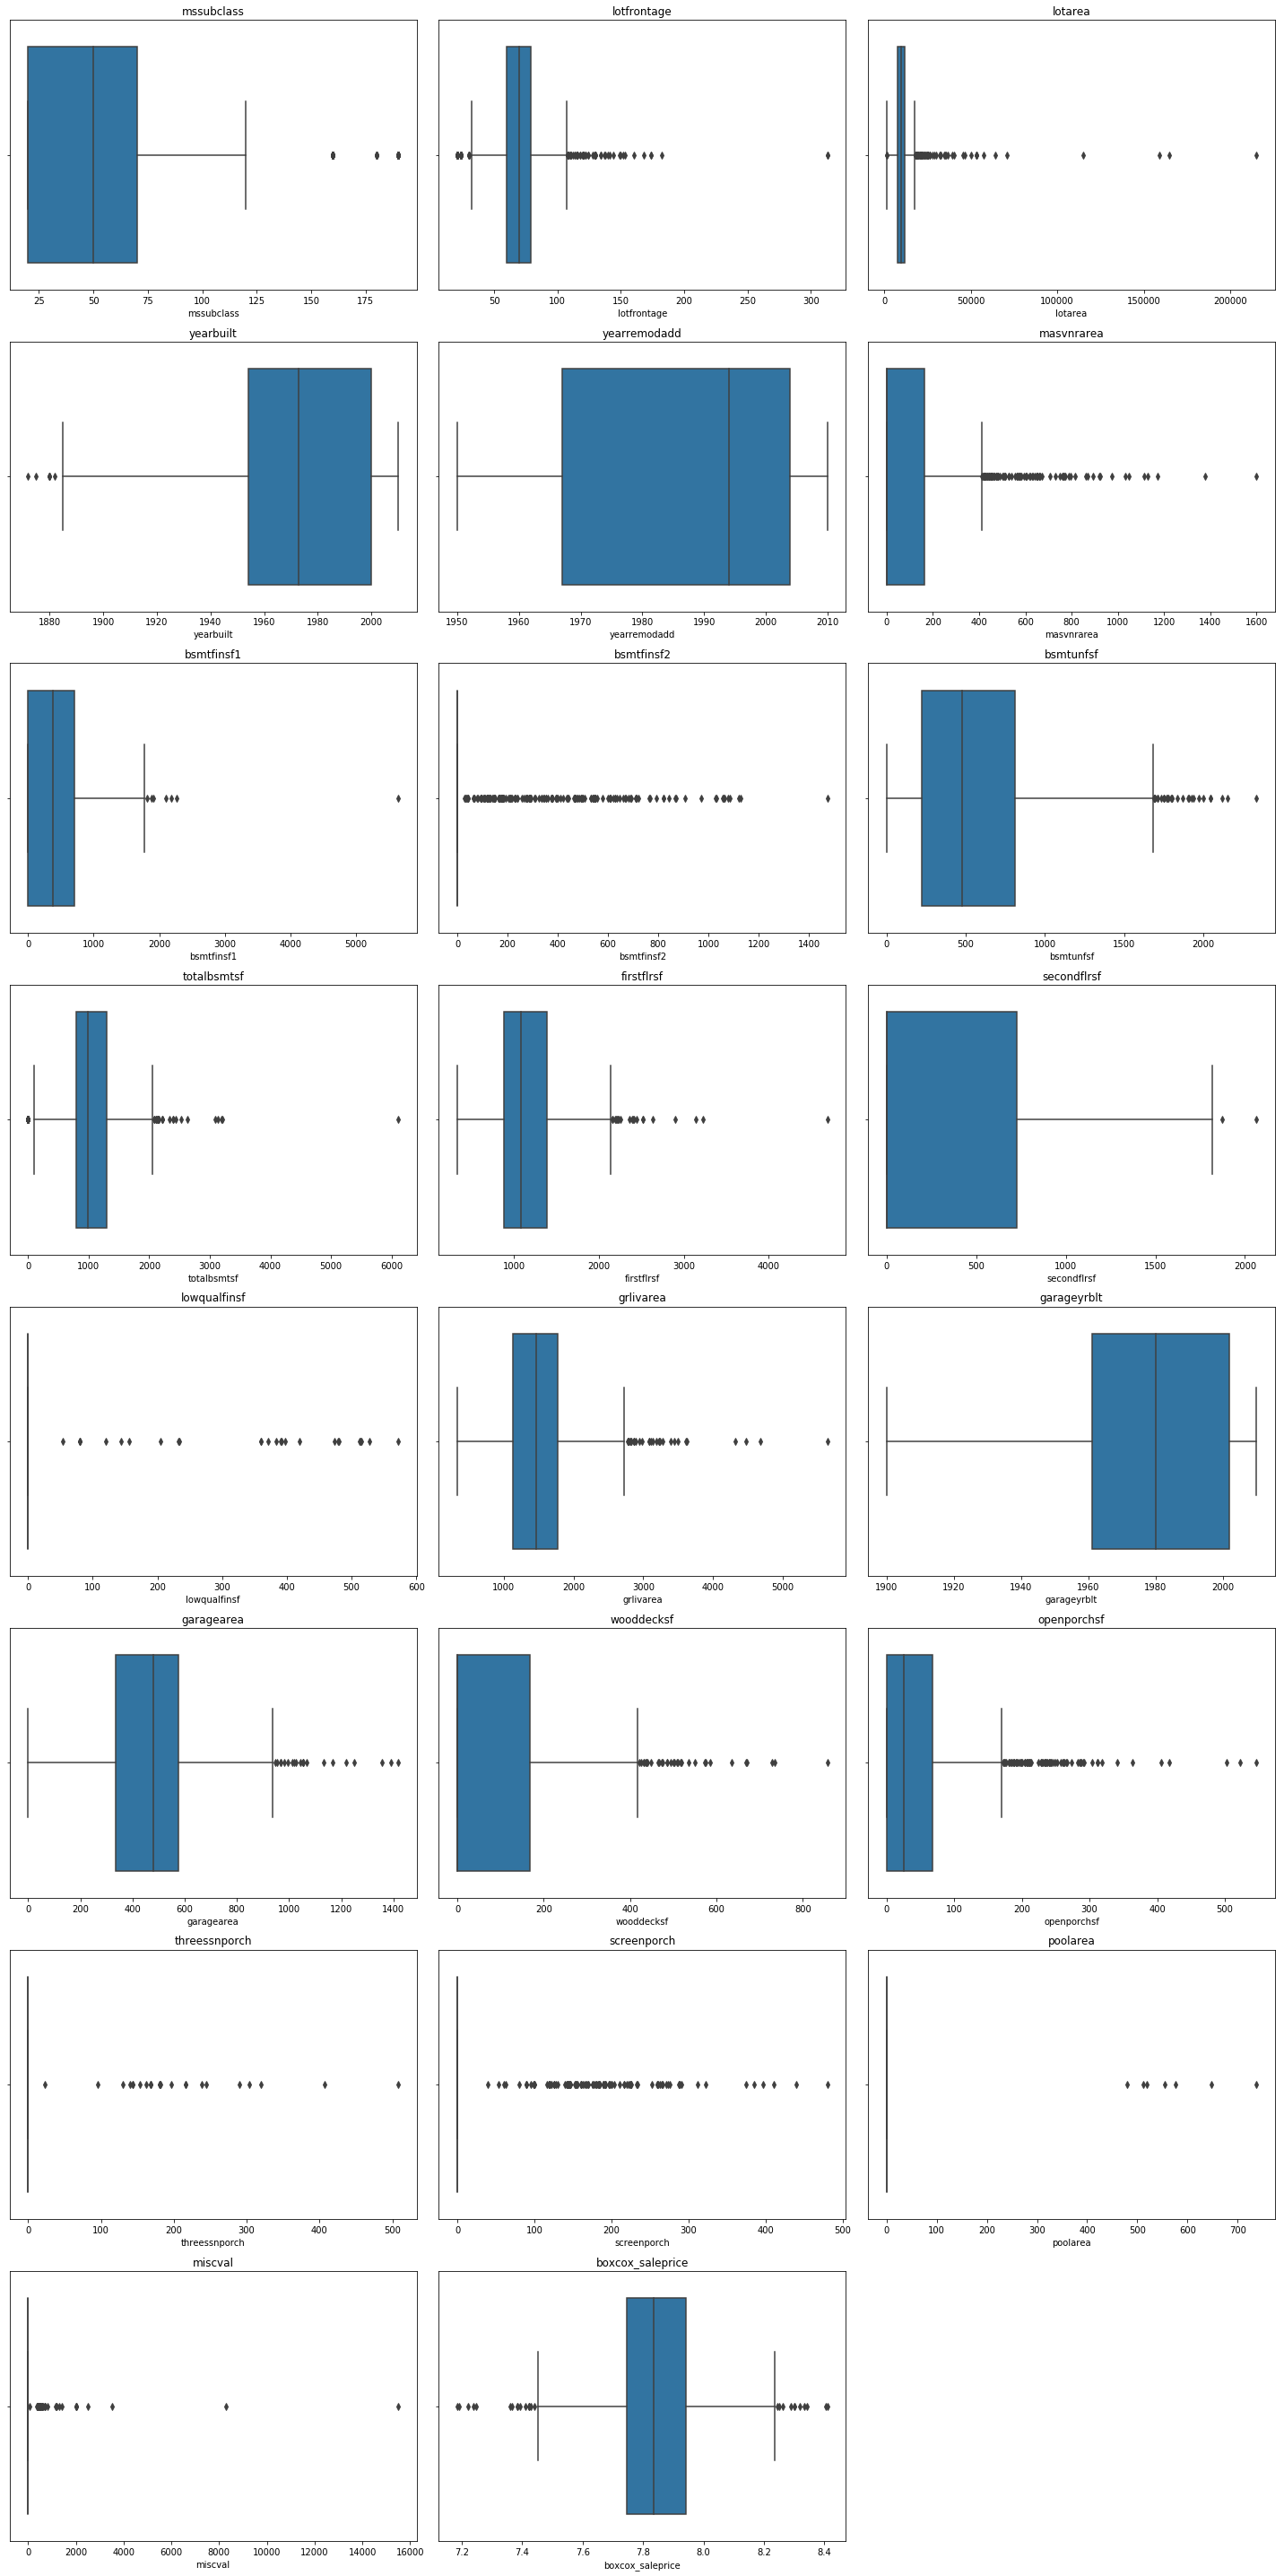

In [29]:
plt.figure(figsize=(20,40))

for variable, i in hp_cont_dict.items():
                     plt.subplot(8, 3, i)
                     sns.boxplot(hp_cont[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

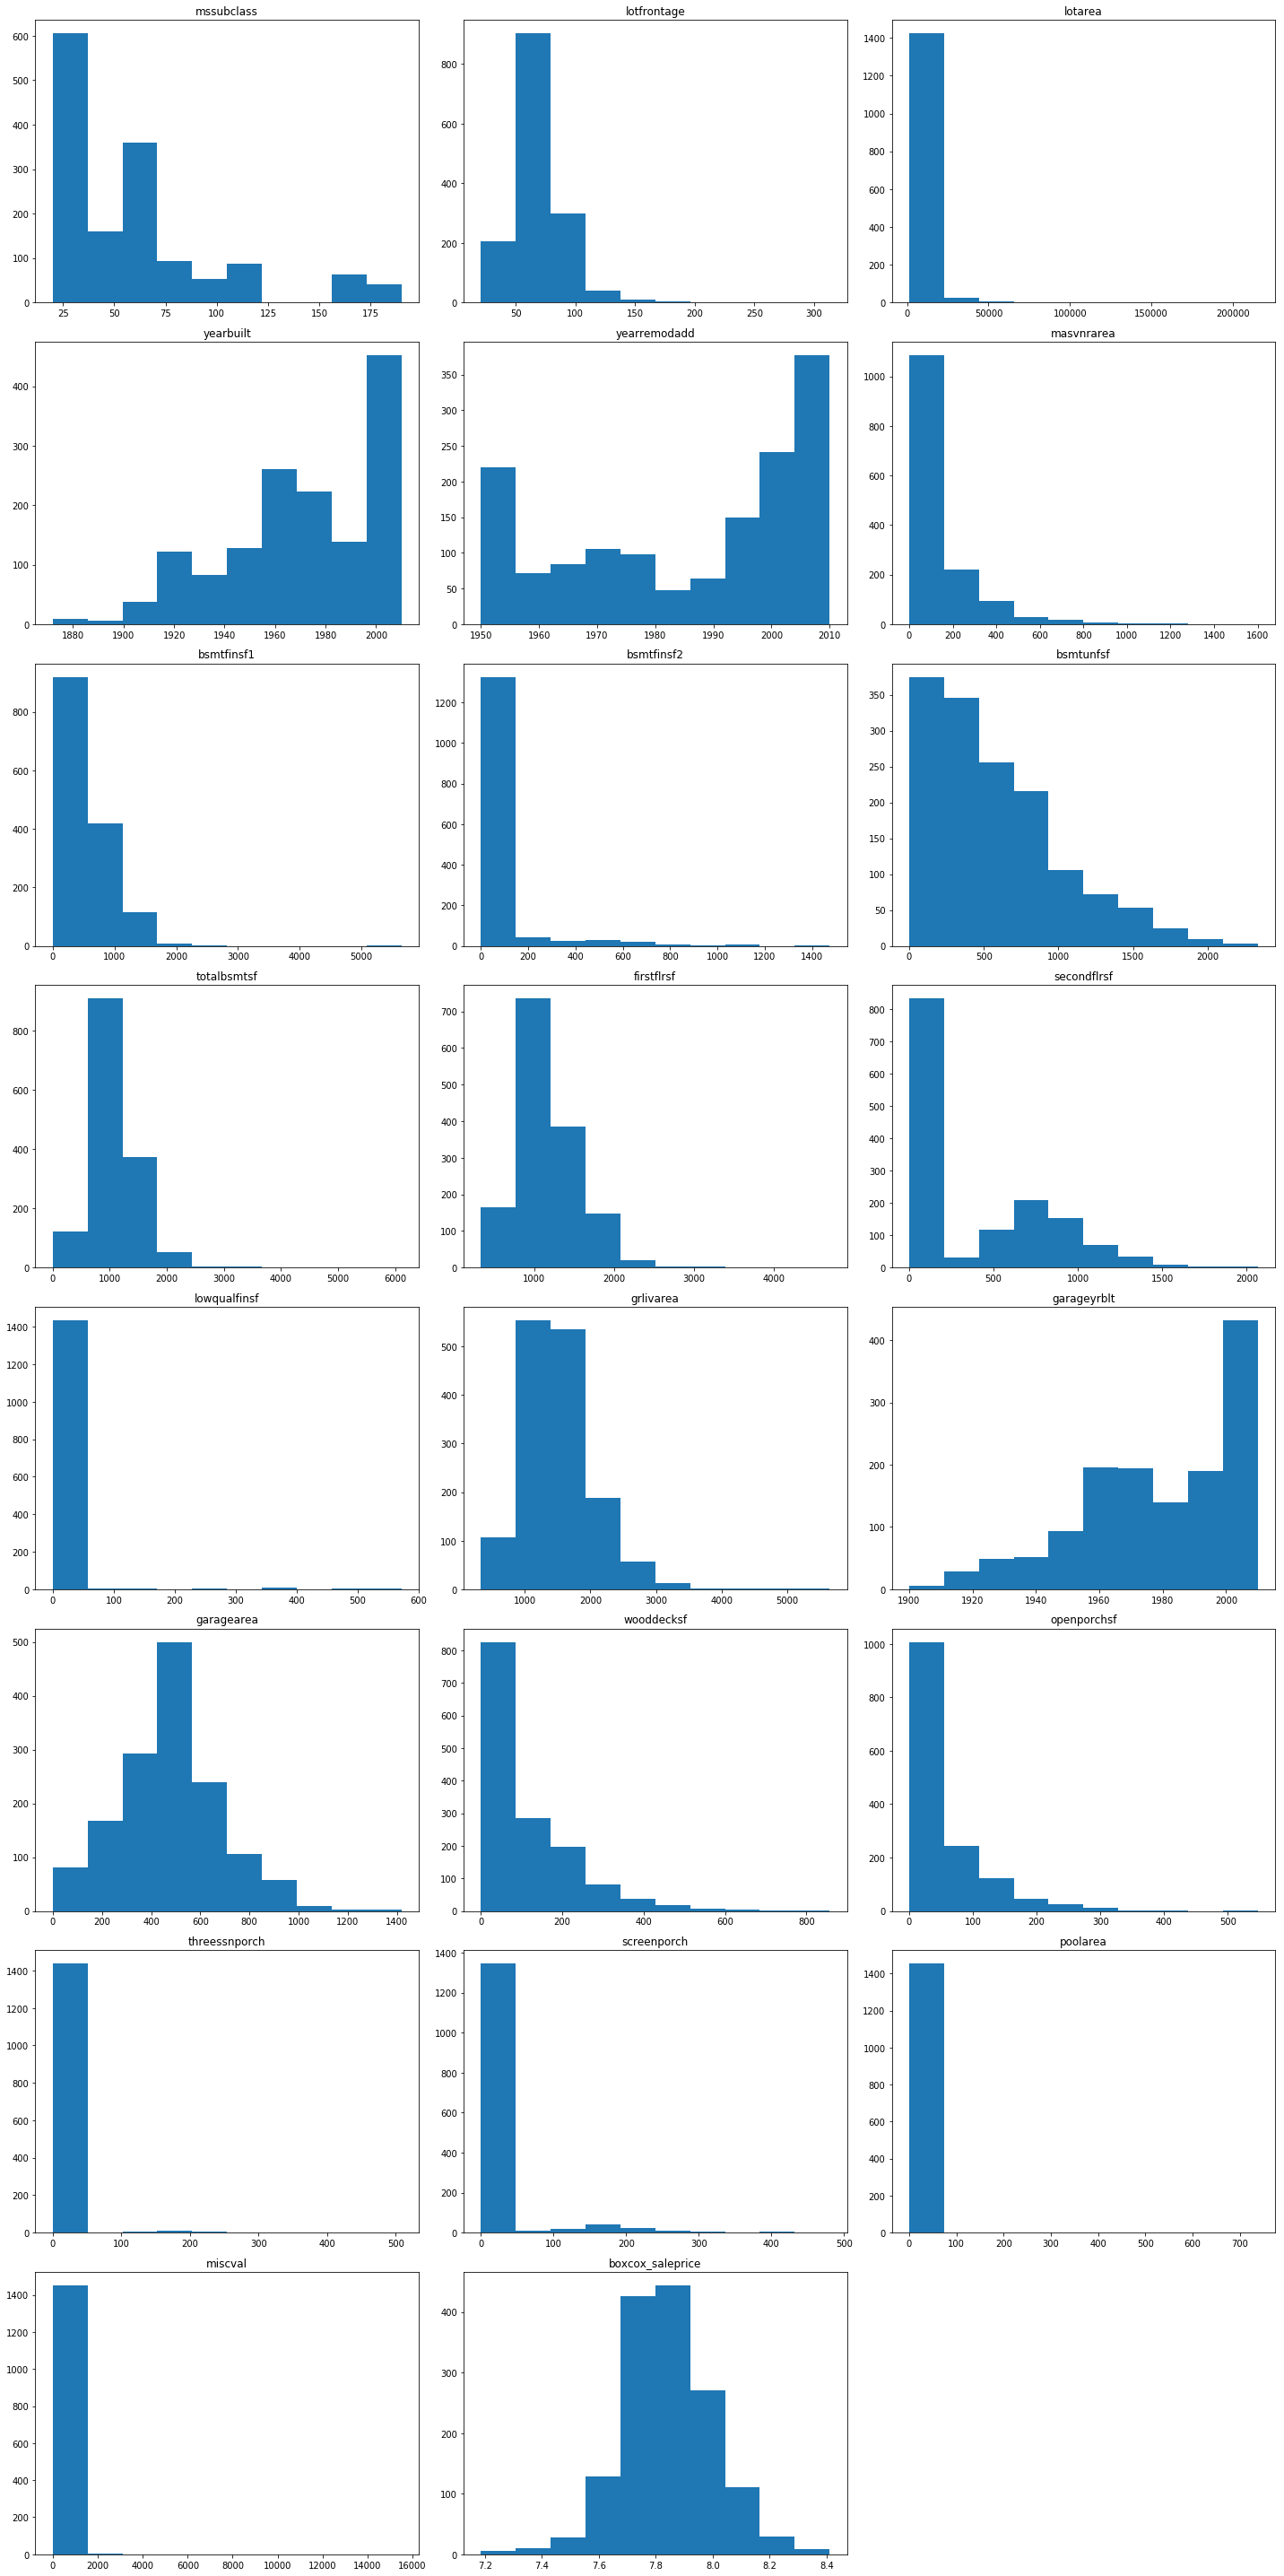

In [30]:
plt.figure(figsize=(20,40))

for variable, i in hp_cont_dict.items():
                     plt.subplot(8, 3, i)
                     plt.hist(hp_cont[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

In [32]:
#clean up some of the variables with outliers by winsorization
import scipy.stats as stats
from scipy.stats.mstats import winsorize

hp_cont['wins_lotfrontage'] = winsorize(hp_cont['lotfrontage'], (0, 0.05))
hp_cont['wins_lotarea'] = winsorize(hp_cont['lotarea'], (0, 0.05))
hp_cont['wins_masvnrarea'] = winsorize(hp_cont['masvnrarea'], (0, 0.05))
hp_cont['wins_bsmtfinsf1'] = winsorize(hp_cont['bsmtfinsf1'], (0, 0.05))
hp_cont['wins_bsmtunfsf'] = winsorize(hp_cont['bsmtunfsf'], (0, 0.05))
hp_cont['wins_totalbsmtsf'] = winsorize(hp_cont['totalbsmtsf'], (0, 0.05))
hp_cont['wins_firstflrsf'] = winsorize(hp_cont['firstflrsf'], (0, 0.05))
hp_cont['wins_grlivarea'] = winsorize(hp_cont['grlivarea'], (0, 0.05))
hp_cont['wins_garagearea'] = winsorize(hp_cont['garagearea'], (0, 0.05))
hp_cont['wins_wooddecksf'] = winsorize(hp_cont['wooddecksf'], (0, 0.05))
hp_cont['wins_openporchsf'] = winsorize(hp_cont['openporchsf'], (0, 0.05))

In [36]:
hp_cont_wins = hp_cont.loc[:, ['wins_lotfrontage', 'wins_lotarea', 'wins_masvnrarea', 'wins_bsmtfinsf1', 'wins_totalbsmtsf', 
                               'wins_firstflrsf', 'wins_grlivarea', 'wins_garagearea', 'wins_wooddecksf','wins_openporchsf']]

list1 = hp_cont_wins[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8]
hp_cont_wins_dict = dict( zip( list1, list2))
print(hp_cont_wins_dict)

{'wins_lotfrontage': 1, 'wins_lotarea': 2, 'wins_masvnrarea': 3, 'wins_bsmtfinsf1': 4, 'wins_totalbsmtsf': 5, 'wins_firstflrsf': 6, 'wins_grlivarea': 7, 'wins_garagearea': 8}


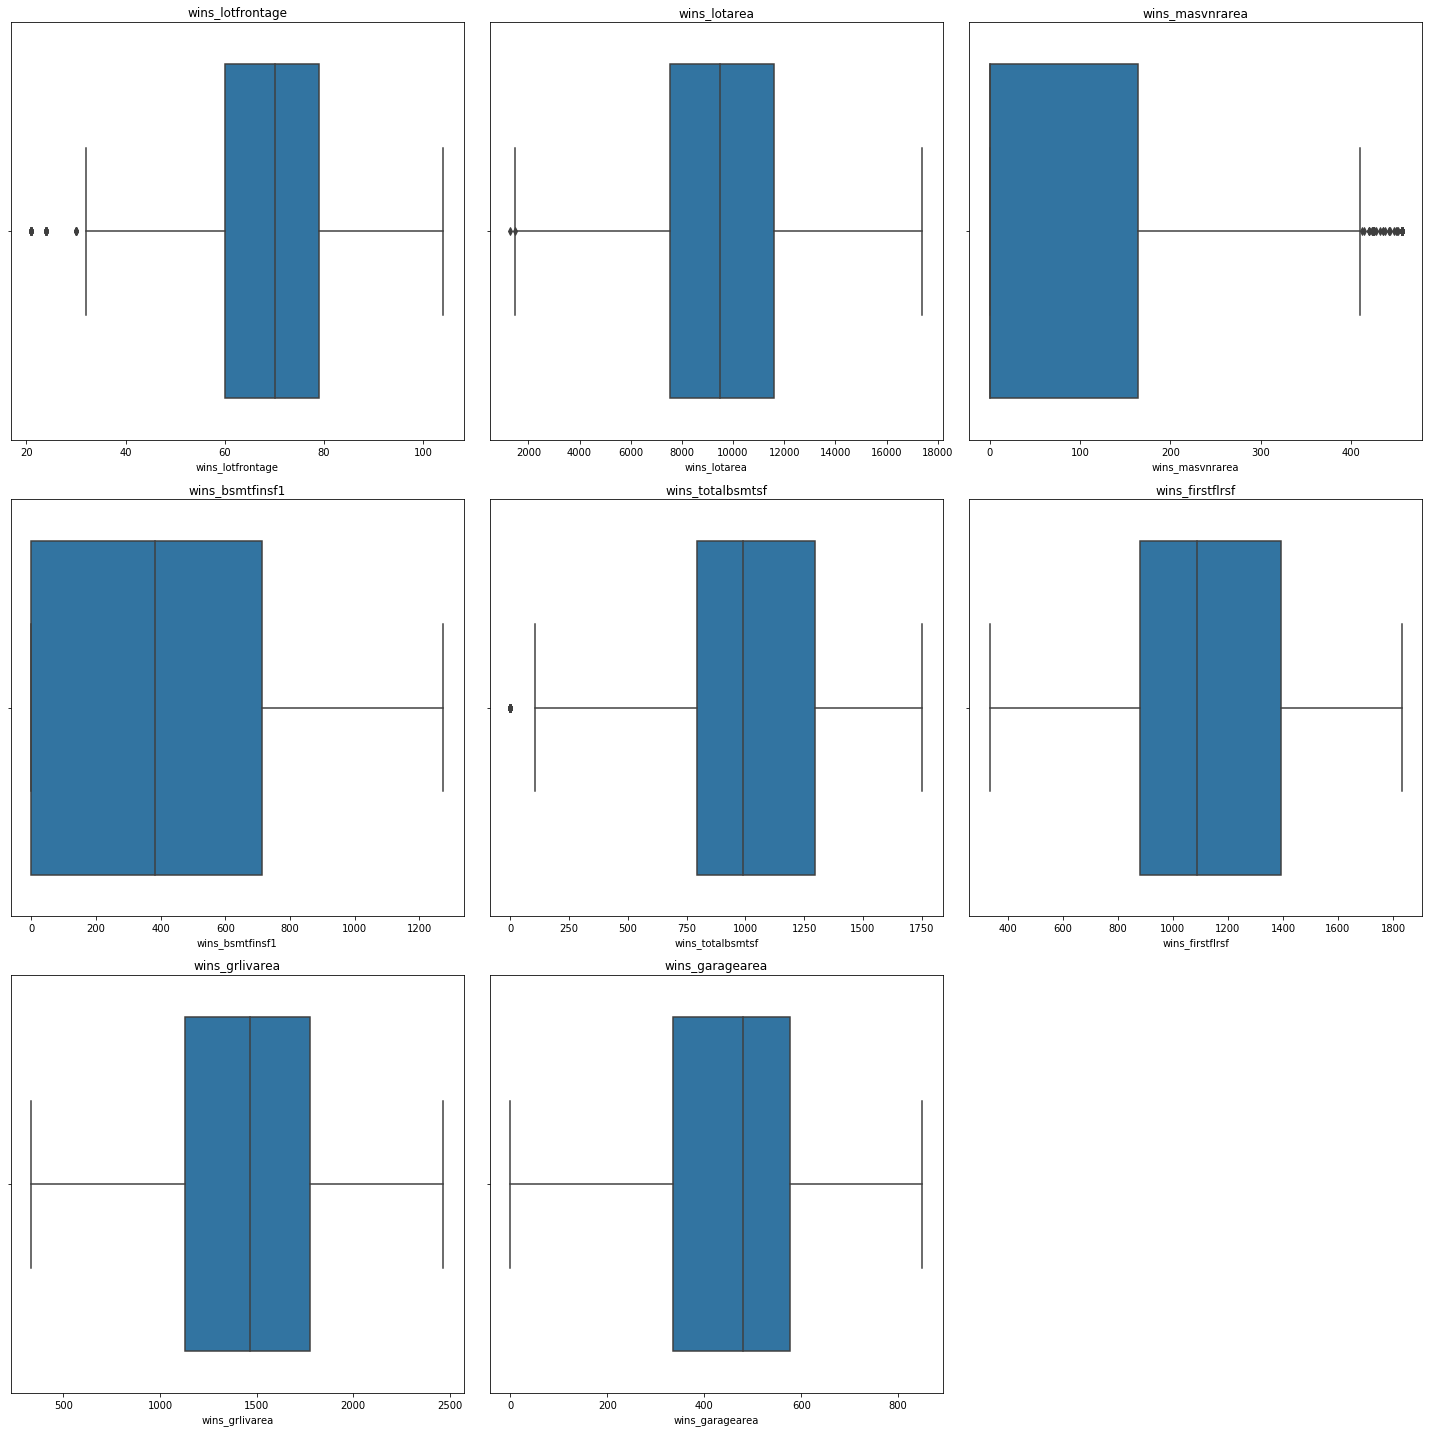

In [38]:
plt.figure(figsize=(20,20))

for variable, i in hp_cont_wins_dict.items():
                     plt.subplot(3, 3, i)
                     sns.boxplot(hp_cont_wins[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

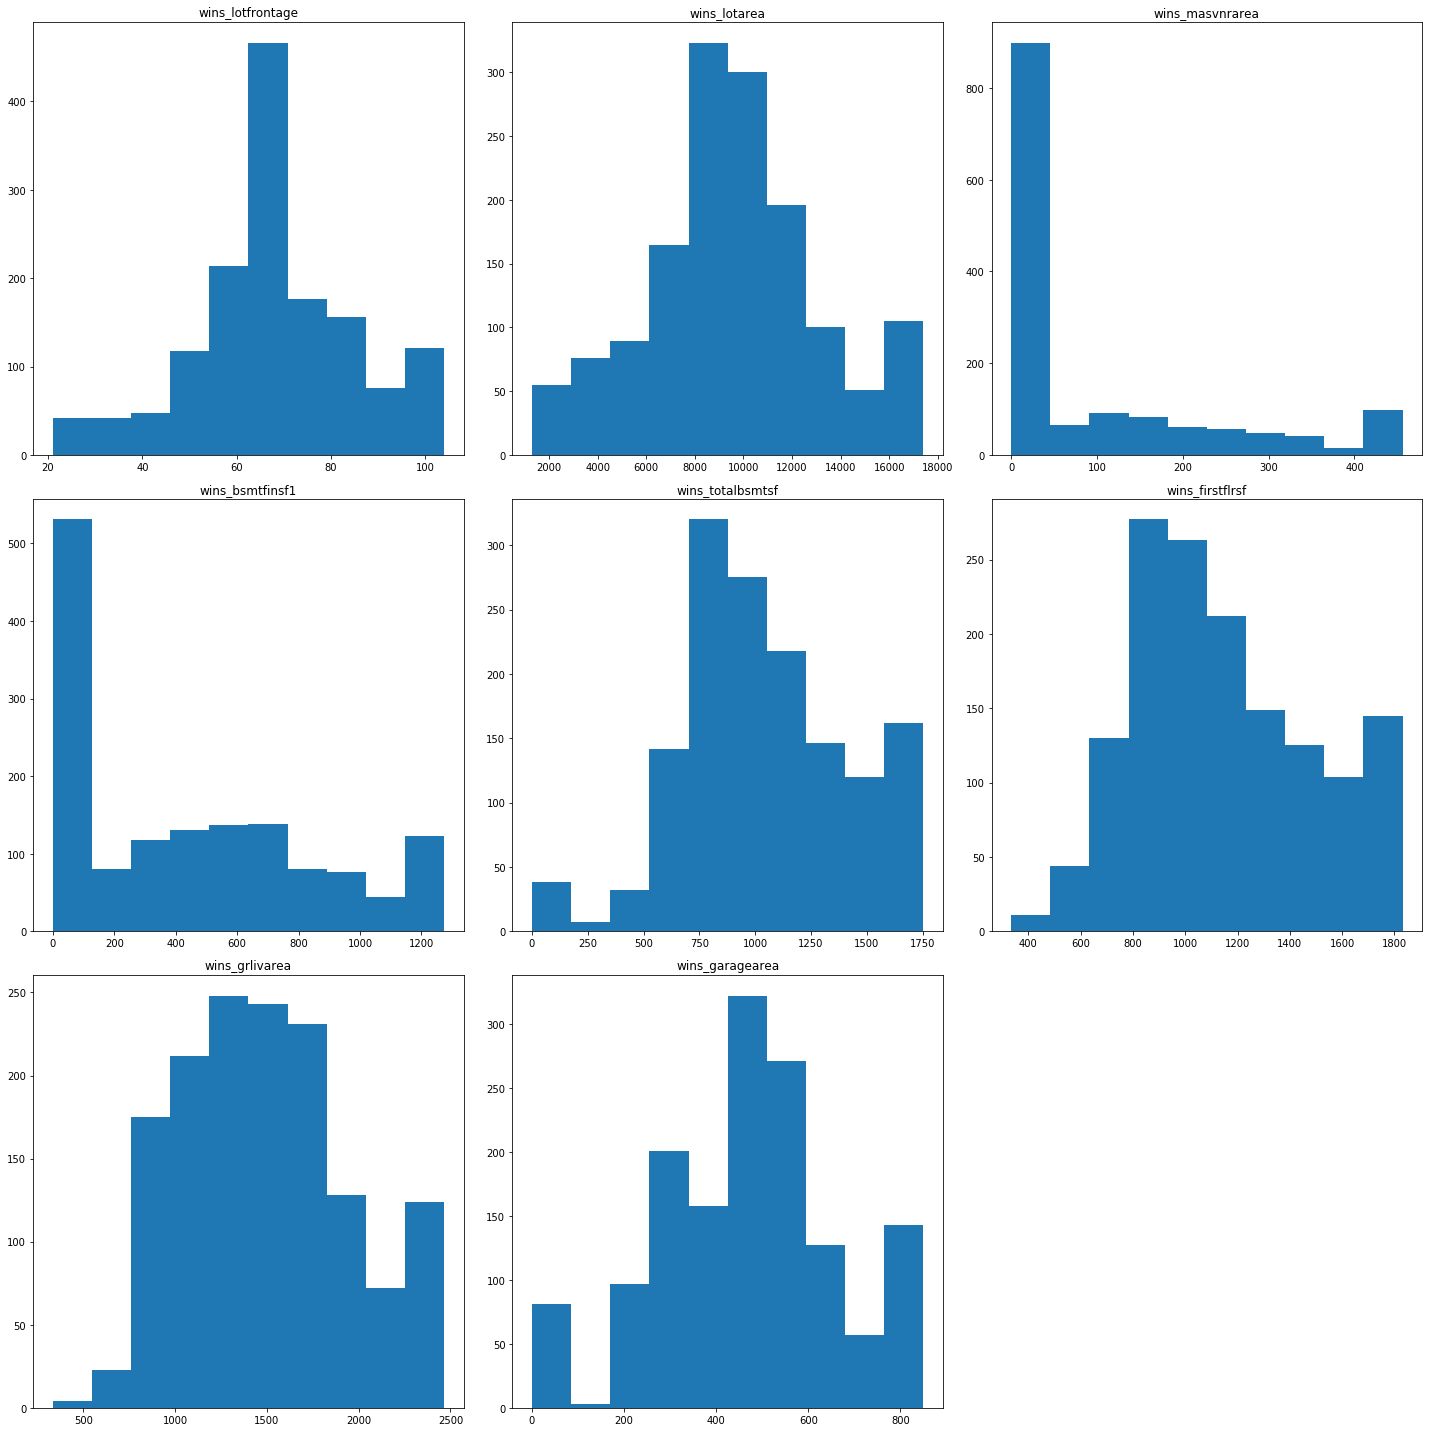

In [39]:
plt.figure(figsize=(20,20))

for variable, i in hp_cont_wins_dict.items():
                     plt.subplot(3, 3, i)
                     plt.hist(hp_cont_wins[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

Winsorization took care of the outliers and the new variables appear to be more normally distributed. 

In [41]:
#drop unwinsorized columns for correlation 
hp_cont.drop(columns = ['lotfrontage', 'lotarea', 'masvnrarea', 'bsmtfinsf1', 'bsmtunfsf', 'totalbsmtsf', 
                         'firstflrsf', 'grlivarea', 'garagearea', 'wooddecksf', 'openporchsf'], inplace = True)

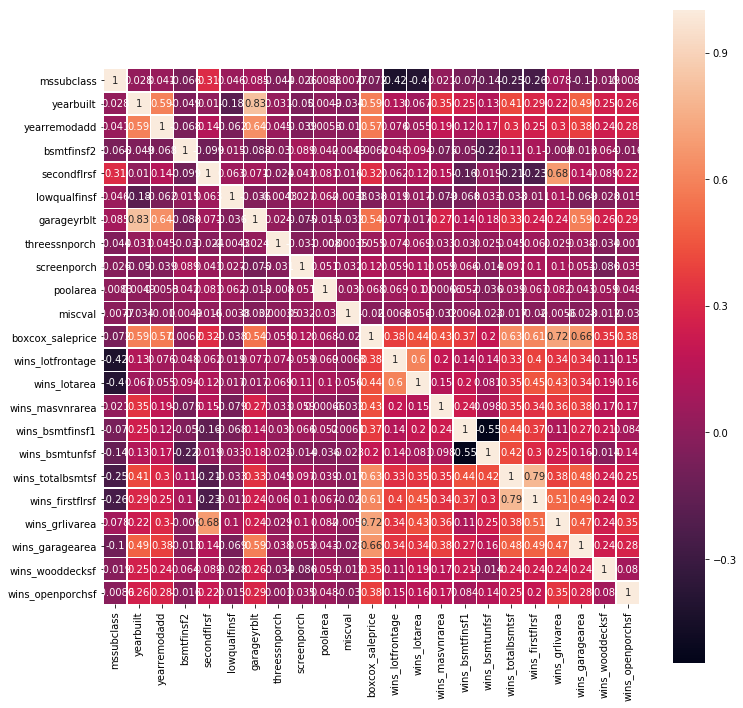

In [42]:
cor_map = hp_cont.corr()

fig, ax = plt.subplots(figsize = (12, 12))
sns.heatmap(cor_map, square=True, annot=True, linewidths=.5, ax = ax)

{'mssubclass': 1, 'yearbuilt': 2, 'yearremodadd': 3, 'bsmtfinsf2': 4, 'secondflrsf': 5, 'lowqualfinsf': 6, 'garageyrblt': 7, 'threessnporch': 8, 'screenporch': 9, 'poolarea': 10, 'miscval': 11, 'boxcox_saleprice': 12, 'wins_lotfrontage': 13, 'wins_lotarea': 14, 'wins_masvnrarea': 15, 'wins_bsmtfinsf1': 16, 'wins_bsmtunfsf': 17, 'wins_totalbsmtsf': 18, 'wins_firstflrsf': 19, 'wins_grlivarea': 20, 'wins_garagearea': 21, 'wins_wooddecksf': 22, 'wins_openporchsf': 23}


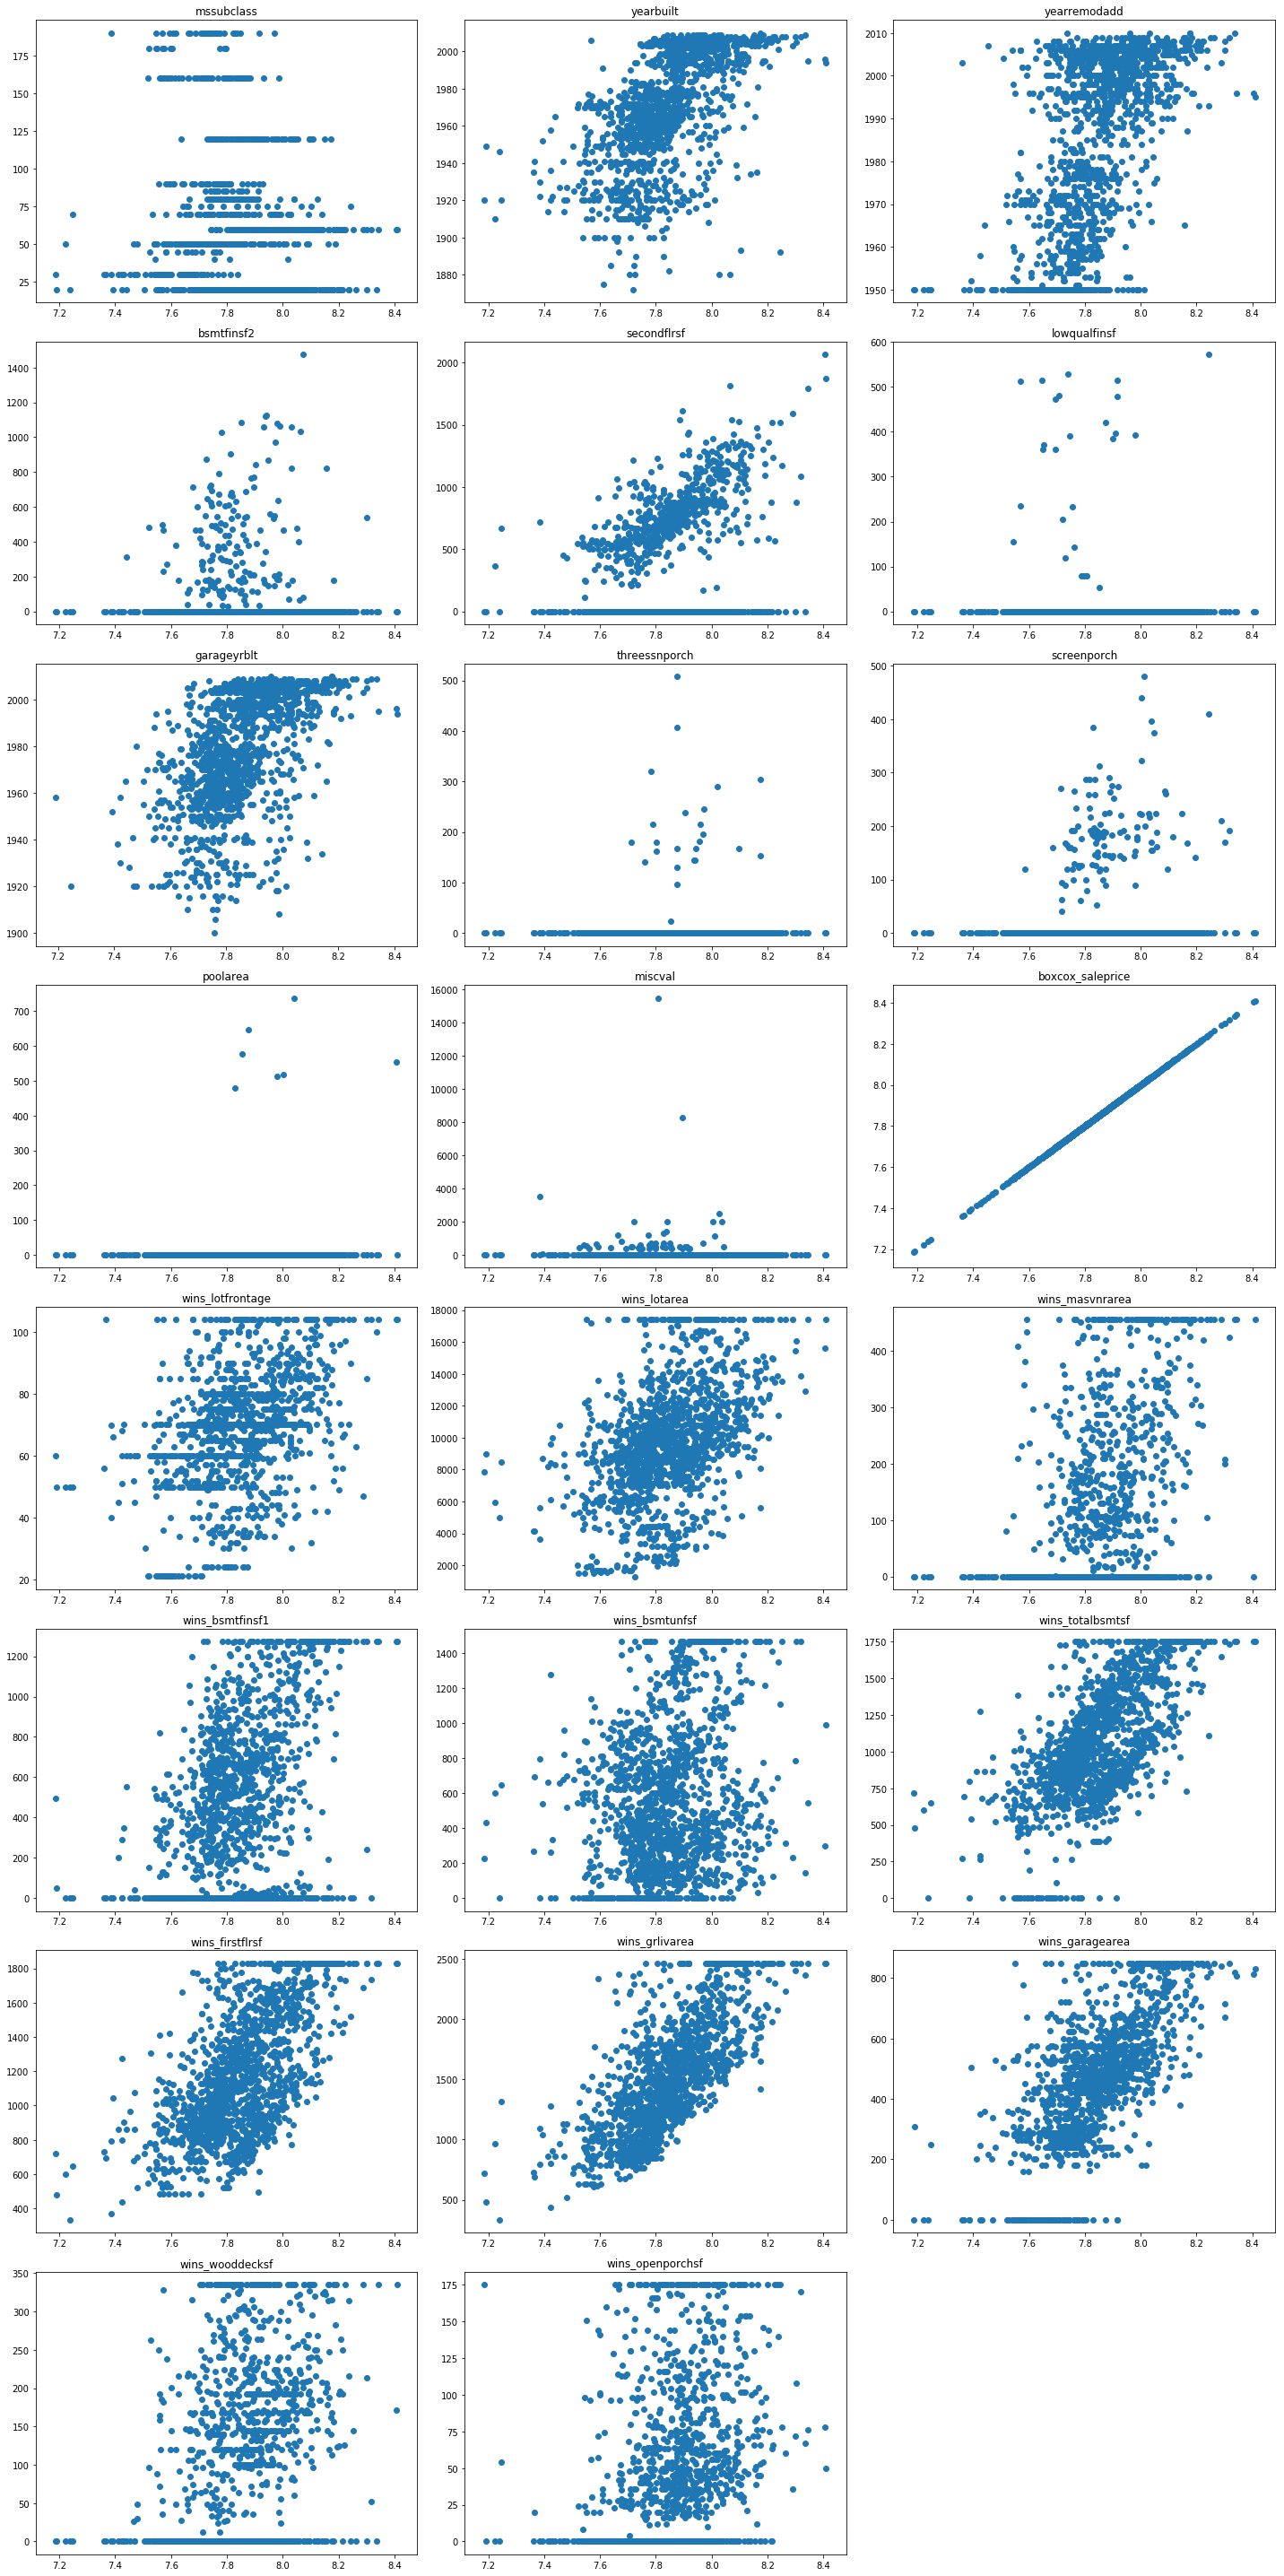

In [43]:
list1 = hp_cont[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
hp_cont2_dict = dict( zip( list1, list2))
print(hp_cont2_dict)

plt.figure(figsize=(20,40))

for variable, i in hp_cont2_dict.items():
                     plt.subplot(8, 3, i)
                     plt.scatter(x = hp_cont['boxcox_saleprice'], y = hp_cont[variable])
                     plt.title(variable)

plt.tight_layout()
plt.show()

Looking at all the continuous variables that have been cleaned, it appears that the most correlated variables to saleprice are garagearea, grlivarea, firstflrsf, and totalbsmtsf. We will use these four variables along with the other variables we found previously to build our regression model. 

In [45]:
#add winsorized variables to original dataframe
hp['wins_grlivarea'] = winsorize(hp['grlivarea'], (0, 0.05))
hp['wins_garagearea'] = winsorize(hp['garagearea'], (0, 0.05))
hp['wins_totalbsmtsf'] = winsorize(hp['totalbsmtsf'], (0, 0.05))
hp['wins_firstflrsf'] = winsorize(hp['firstflrsf'], (0, 0.05))

## Features Engineering

It seems that there would be a correlation between firstflrsf, totatbsmtsf and secondflrsf. These also all appear to be correlated with saleprice. I want to create a new feature, totalsf, that combines these three variables. Also I want to create dummy variables for the centralair and street variables. 

{'whiskers': [<matplotlib.lines.Line2D at 0x1c9c95cb898>,
 'caps': [<matplotlib.lines.Line2D at 0x1c9c95cbf28>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c9c95cb470>],
 'medians': [<matplotlib.lines.Line2D at 0x1c9c95c55f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c9c95c5940>],
 'means': []}

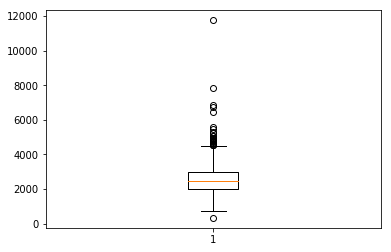

In [47]:
hp['totalsf'] = hp['secondflrsf'] + hp['firstflrsf'] + hp['totalbsmtsf']

plt.boxplot(hp.totalsf)

{'whiskers': [<matplotlib.lines.Line2D at 0x1c9c945ff98>,
 'caps': [<matplotlib.lines.Line2D at 0x1c9c9450940>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c9c945fe48>],
 'medians': [<matplotlib.lines.Line2D at 0x1c9c9450fd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c9c555d358>],
 'means': []}

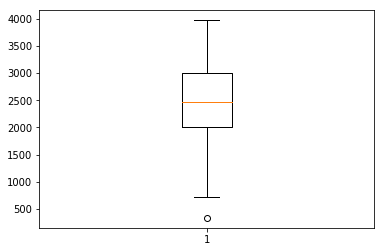

In [48]:
hp['wins_totalsf'] = winsorize(hp['totalsf'], (0, 0.05))

plt.boxplot(hp.wins_totalsf)

In [49]:
hp["dummies_street"] = pd.get_dummies(hp.street, drop_first=True)
hp["dummies_centralair"] = pd.get_dummies(hp.centralair, drop_first=True)

## Begin Modelling

In [50]:
# Build first linear regression model
Y = hp['boxcox_saleprice']
 
X = hp[['overallqual', 'fullbath', 'garagecars', 'wins_totalsf', 'wins_grlivarea', 'wins_garagearea']]

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [4.54478093e-02 1.06475985e-02 2.52799370e-02 8.65108997e-05
 1.05728864e-05 5.97570805e-05]

Intercept: 
 7.2406601625372815


In [51]:
import statsmodels.api as sm

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       boxcox_saleprice   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1078.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:31:54   Log-Likelihood:                 1858.4
No. Observations:                1460   AIC:                            -3703.
Df Residuals:                    1453   BIC:                            -3666.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.2407      0.008    877.453      0.000       7.224       7.257
overallqual         0.0454      0.002     23.750      0.000       0.042       0.049
fullbath            0.0106      0.004      2.405      0.016       0.002       0.019
garagecars          0.0253      0.006      4.512      0.000       0.014       0.036
wins_totalsf     8.651e-05   5.59e-06     15.466      0.000    7.55e-05    9.75e-05
wins_grlivarea   1.057e-05   8.09e-06      1.307      0.191   -5.29e-06    2.64e-05
wins_garagearea  5.976e-05   2.03e-05      2.941      0.003    1.99e-05    9.96e-05
==============================================================================
Omnibus:                      410.246   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1740.346
Skew:                          -1.283   Prob(JB):                         0.00
Kurtosis:                       7.693   Cond. No.                     1.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The first model seems to be performing fairly well with an adjusted R-squared value of 0.816. Let's try another by adding some variables and removing a couple. 

In [78]:
# Second model - add yearbuilt and dummies_centralair, remove fullbath and garagecars
Y = hp['boxcox_saleprice']

# X is the feature set 
X = hp[['overallqual', 'wins_totalsf', 'yearbuilt', 'wins_grlivarea', 'wins_garagearea', 'dummies_centralair']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       boxcox_saleprice   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1293.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:17:12   Log-Likelihood:                 1968.5
No. Observations:                1460   AIC:                            -3923.
Df Residuals:                    1453   BIC:                            -3886.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.7125      0.139     41.170      0.000       5.440       5.985
overallqual            0.0364      0.002     19.257      0.000       0.033       0.040
wins_totalsf        7.475e-05   5.22e-06     14.309      0.000    6.45e-05     8.5e-05
yearbuilt              0.0008   7.35e-05     10.601      0.000       0.001       0.001
wins_grlivarea      4.807e-05   7.32e-06      6.566      0.000    3.37e-05    6.24e-05
wins_garagearea     9.694e-05   1.09e-05      8.917      0.000    7.56e-05       0.000
dummies_centralair     0.0698      0.007      9.598      0.000       0.056       0.084
==============================================================================
Omnibus:                      345.047   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1626.671
Skew:                          -1.034   Prob(JB):                         0.00
Kurtosis:                       7.739   Cond. No.                     3.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This next model is performing even better than the first. I will proceed with this model by first checking to make sure it is meeting all of the assumptions. 

## Meeting the assumptions of Linear Regression

### Assumption one: linearity of the model in its coefficients

In [61]:
Y = hp['boxcox_saleprice']
X = hp[['overallqual', 'wins_totalsf', 'yearbuilt', 'wins_grlivarea', 'wins_garagearea', 'dummies_centralair']]

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

list1 = list(X.columns)
list2 = [1, 2, 3, 4, 5, 6, 7]
X_variables = dict( zip( list1, list2))
print(X_variables)

{'overallqual': 1, 'wins_totalsf': 2, 'yearbuilt': 3, 'wins_grlivarea': 4, 'wins_garagearea': 5, 'dummies_centralair': 6}


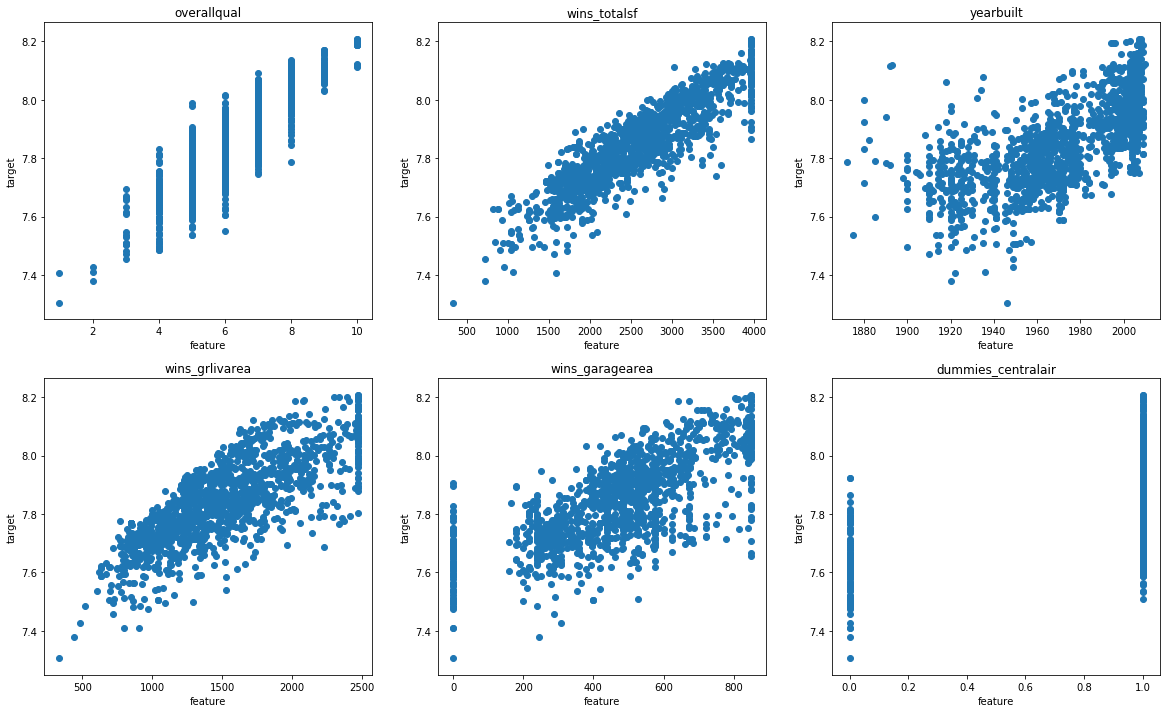

In [63]:
predictions = lrm.predict(X)

plt.figure(figsize=(20,12))


for variable, i in X_variables.items():
                     plt.subplot(2, 3, i)
                     plt.scatter(X[variable], predictions)
                     plt.xlabel("feature")
                     plt.ylabel("target")
                     plt.title(variable)


Assumption met, all are showing a linear relationship

### Assumption two: the error term should be zero on average

In [65]:
errors = Y - predictions

print("Mean of the errors in the houseprices model is: {}".format(np.mean(errors)))

Mean of the errors in the houseprices model is: 3.333710780792251e-16


Assumption met

### Assumption three: homoscedasticity

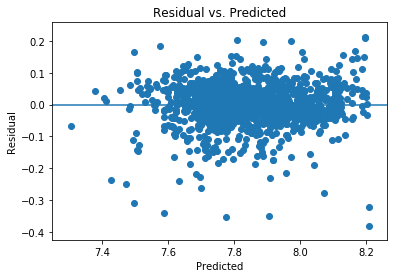

In [66]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [67]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 921.972 and p value is 1.64e-202
Levene test statistic value is 824.516 and p value is 6.47e-160


Assumption not met, data is heteroscedastic

### Assumption four: low multicollinearity

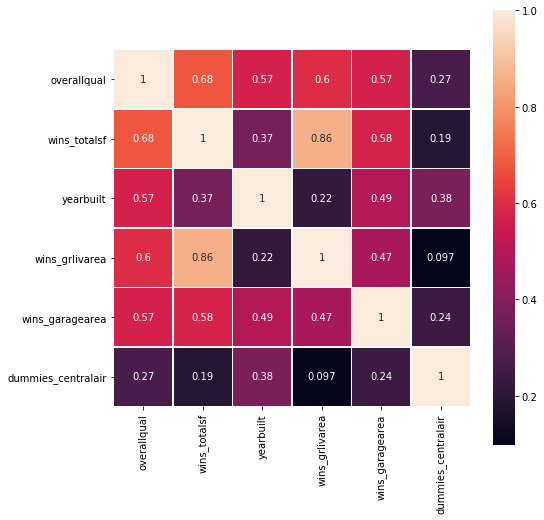

In [68]:
cor_map = X.corr()
fig, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(cor_map, square=True, annot=True, linewidths=.5, ax = ax)

The wins_grlivarea and wins_totalsf variables are correlated, may have to remove one of them. 

### Assumption five: error terms should be uncorrelated with one another

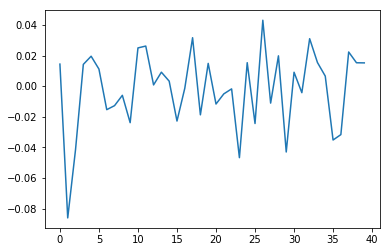

In [70]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Assumption met, errors do not appear correlated

### Assumption six: features shouldn't be correlated with the errors

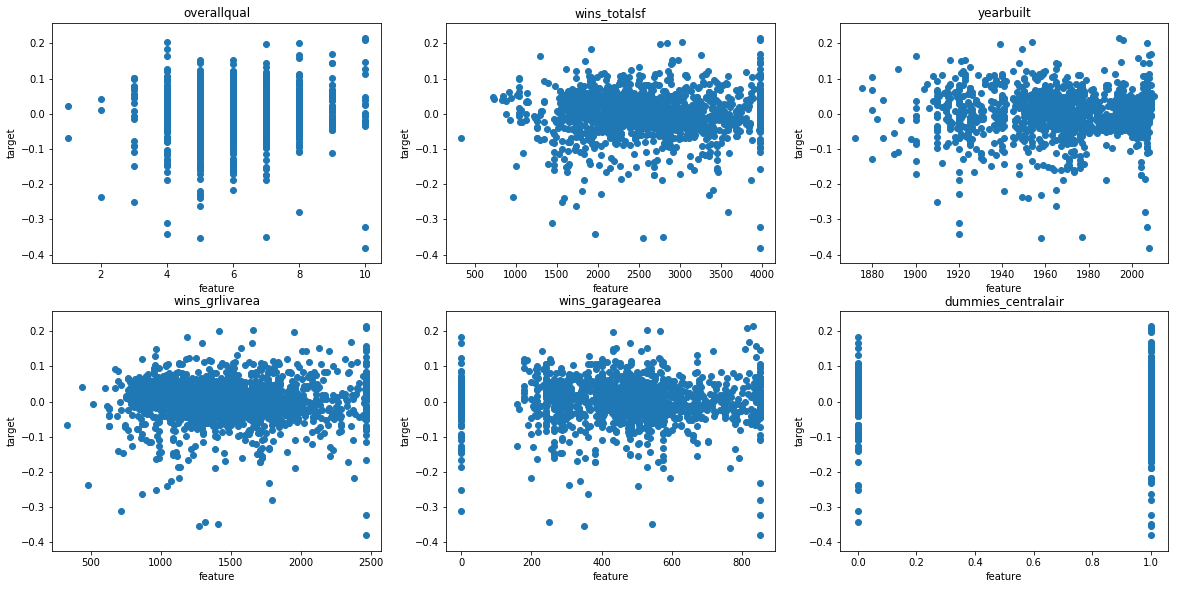

In [71]:
plt.figure(figsize=(20,15))


for variable, i in X_variables.items():
                     plt.subplot(2, 3, i)
                     plt.scatter(X[variable], errors)
                     plt.xlabel("feature")
                     plt.ylabel("target")
                     plt.title(variable)


Assumption met. The features do not appear to be correlated with the errors. 

Text(0.5, 1.0, 'Histogram of the errors')

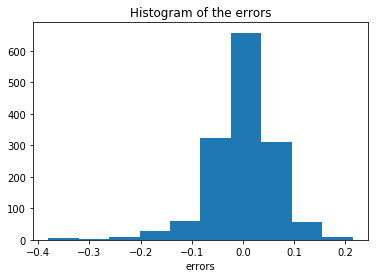

In [72]:
#looking for normality of the error terms

plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

In [73]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 1626.670745548883 and p value is 0.0
Normality test statistics is 345.04728998358905 and p value is 1.1855857814206388e-75


The errors appear normally distributed in the histogram, but are not according to the normality tests. 

## Evaluating Model Performance

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

X = hp[['overallqual', 'fullbath', 'garagecars', 'wins_totalsf', 'wins_grlivarea', 'wins_garagearea']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

results.summary()

The number of observations in training set is 1168
The number of observations in test set is 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       boxcox_saleprice   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     868.6
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:30:19   Log-Likelihood:                 1498.1
No. Observations:                1168   AIC:                            -2982.
Df Residuals:                    1161   BIC:                            -2947.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.2394      0.009    784.591      0.000       7.221       7.258
overallqual         0.0462      0.002     21.383      0.000       0.042       0.050
fullbath            0.0079      0.005      1.624      0.105      -0.002       0.017
garagecars          0.0247      0.006      3.852      0.000       0.012       0.037
wins_totalsf     8.597e-05   6.11e-06     14.071      0.000     7.4e-05     9.8e-05
wins_grlivarea   1.266e-05   8.87e-06      1.428      0.154   -4.74e-06    3.01e-05
wins_garagearea  5.974e-05   2.28e-05      2.617      0.009     1.5e-05       0.000
==============================================================================
Omnibus:                      336.671   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1403.551
Skew:                          -1.312   Prob(JB):                    1.67e-305
Kurtosis:                       7.685   Cond. No.                     1.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

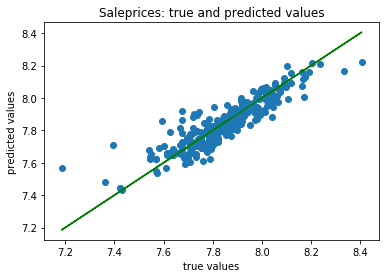

Mean absolute error of the prediction is: 0.04970298758612943
Mean squared error of the prediction is: 0.004953091195649576
Root mean squared error of the prediction is: 0.07037820113962544
Mean absolute percentage error of the prediction is: 0.6366687217036534


In [85]:
#making predictions - first model
X_test = sm.add_constant(X_test)

Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color="green")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Saleprices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds) / Y_test)) * 100))

In [82]:
# second model
X = hp[['overallqual', 'wins_totalsf', 'yearbuilt', 'wins_grlivarea', 'wins_garagearea', 'dummies_centralair']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

results.summary()

The number of observations in training set is 1168
The number of observations in test set is 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       boxcox_saleprice   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     1026.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:29:09   Log-Likelihood:                 1578.7
No. Observations:                1168   AIC:                            -3143.
Df Residuals:                    1161   BIC:                            -3108.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.8530      0.156     37.577      0.000       5.547       6.159
overallqual            0.0375      0.002     17.476      0.000       0.033       0.042
wins_totalsf        7.507e-05   5.75e-06     13.065      0.000    6.38e-05    8.63e-05
yearbuilt              0.0007   8.25e-05      8.520      0.000       0.001       0.001
wins_grlivarea      4.881e-05   8.19e-06      5.963      0.000    3.27e-05    6.49e-05
wins_garagearea     9.683e-05   1.21e-05      8.032      0.000    7.32e-05       0.000
dummies_centralair     0.0712      0.008      8.711      0.000       0.055       0.087
==============================================================================
Omnibus:                      306.858   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1499.291
Skew:                          -1.136   Prob(JB):                         0.00
Kurtosis:                       8.064   Cond. No.                     3.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

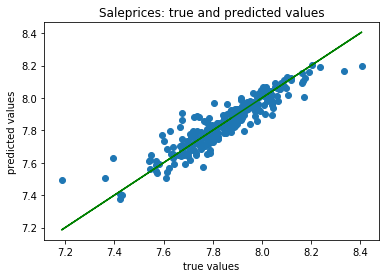

Mean absolute error of the prediction is: 0.04471381148086507
Mean squared error of the prediction is: 0.004073934847899805
Root mean squared error of the prediction is: 0.06382738321363178
Mean absolute percentage error of the prediction is: 0.5723202924756942


In [83]:
#making predictions - second model
X_test = sm.add_constant(X_test)

Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color="green")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Saleprices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds) / Y_test)) * 100))

Again comparing the two models the second model had the best performance in terms of goodness of fit measures and prediction metrics. It had a higher adjusted R-squared and lower AIC & BIC values. Also, the prediction metrics were pretty similar but the second model had a lower mean absolute percentage than the first. There could still be some improvements but overall I think it is performing well. I will now test the model and see if there is any overfitting by looking at the Ridge, Lasso and ElasticNet regressions. 

In [93]:
# OLS model
Y = hp['boxcox_saleprice']
X = hp[['overallqual', 'wins_totalsf', 'yearbuilt', 'wins_grlivarea', 'wins_garagearea', 'dummies_centralair']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

lrm = linear_model.LinearRegression()

lrm.fit(X_train, Y_train)

Y_preds_train = lrm.predict(X_train)
Y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model in training set is: 0.8413148894889777
-----Test set statistics-----
R-squared of the model in test set is: 0.8448034835589076
Mean absolute error of the prediction is: 0.04471381148086809
Mean squared error of the prediction is: 0.004073934847900259
Root mean squared error of the prediction is: 0.06382738321363535
Mean absolute percentage error of the prediction is: 0.5723202924757287


In [89]:
# import linear regression models and set alphas
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [94]:
# Ridge Regression
ridgeregr = RidgeCV(alphas = alphas, cv =5) 
ridgeregr.fit(X_train, Y_train)

Y_preds_train = ridgeregr.predict(X_train)
Y_preds_test = ridgeregr.predict(X_test)

print("Best alpha value is: {}".format(ridgeregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model on the training set is: 0.8413120021314489
-----Test set statistics-----
R-squared of the model on the test set is: 0.8448455689891624
Mean absolute error of the prediction is: 0.044682774309526836
Mean squared error of the prediction is: 0.0040728300982265184
Root mean squared error of the prediction is: 0.06381872842846775
Mean absolute percentage error of the prediction is: 0.5719201396047404


In [95]:
# Lasso Regression
lassoregr = LassoCV(alphas = alphas, cv = 5) 
lassoregr.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = lassoregr.predict(X_train)
Y_preds_test = lassoregr.predict(X_test)

print("Best alpha value is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model on the training set is: 0.8413066542952216
-----Test set statistics-----
R-squared of the model on the test set is: 0.8448865604666167
Mean absolute error of the prediction is: 0.04465139362721879
Mean squared error of the prediction is: 0.004071754064999116
Root mean squared error of the prediction is: 0.0638102974840199
Mean absolute percentage error of the prediction is: 0.5715161557509644


In [96]:
# ElasticNet regression
elasticregr = ElasticNetCV(alphas=alphas, cv=5) 
elasticregr.fit(X_train, Y_train)

Y_preds_train = elasticregr.predict(X_train)
Y_preds_test = elasticregr.predict(X_test)

print("Best alpha value is: {}".format(elasticregr.alpha_))
print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model on the training set is: 0.8413125374319204
-----Test set statistics-----
R-squared of the model on the test set is: 0.844849400673982
Mean absolute error of the prediction is: 0.04468078840867033
Mean squared error of the prediction is: 0.004072729515850891
Root mean squared error of the prediction is: 0.0638179403917965
Mean absolute percentage error of the prediction is: 0.5718948347793615


After looking at all of the regression models they all are performing similarly on the training and test sets. This is a good sign that there is no overfitting happening. They also all have very similar prediction measures which is another good sign. 